# Imminent ICU Admission and Prolonged Stay Prediction using Neural Networks

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import pdb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=5)

import pandas as pd
import pickle

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.feature_extraction.text import TfidfVectorizer

from skorch import NeuralNetBinaryClassifier
from skorch.toy import MLPModule
from skorch.dataset import CVSplit
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint

from mlp_model import MLPModel
from utils.splits import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

from args import args
vars(args)

{'workdir': PosixPath('../data/workdir/mlp'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime',
  'chartinterval'],
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'dates': ['charttime', 'intime'],
 'device': 'cuda:2',
 'start_seed': 127,
 'min_freq': 3,
 'batch_size': 128,
 'hidden_dim': 100,
 'dropout_p': 0.1,
 'lr': 0.001,
 'wd': 0.001,
 'max_lr': 0.1,
 'max_epochs': 100,
 'ia_thresh': 0.2,
 'ps_thresh': 0.27}

## NN Dev

In [3]:
seed = 643
full_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ia_df = full_df.loc[(full_df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = full_df.loc[(full_df['chartinterval'] != 0)][args.prolonged_stay_cols].reset_index(drop=True)

### Imminent ICU Admission

In [4]:
ori_df = set_group_splits(ia_df.copy(), group_col='hadm_id', seed=seed)
df = ori_df
# df = ori_df.sample(1000).reset_index(drop=True)

In [5]:
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), binary=True, max_features=60_000)

x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note']).astype(np.float32)
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note']).astype(np.float32)

x_train = np.asarray(x_train.todense())
x_test = np.asarray(x_test.todense())

vocab_sz = len(vectorizer.vocabulary_)

y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50809, 4), (42683, 60000), (8126, 60000), (42683,), (8126,))

In [6]:
train_ds = TensorDataset(torch.tensor(x_train), torch.tensor(y_train.astype(np.float32)))
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, drop_last=True)
itr = iter(train_dl)

In [7]:
clf = MLPModule(input_units=vocab_sz, output_units=1, hidden_units=100, num_hidden=1, dropout=args.dropout_p, squeeze_output=True)

loss_fn = nn.BCEWithLogitsLoss()
x, y = next(itr)
y_pred = clf(x)

loss_fn(y_pred, y)

In [9]:
reduce_lr = LRScheduler(
  policy='ReduceLROnPlateau',
  mode='min',
  factor=0.5,
  patience=1,
)

checkpoint = Checkpoint(
  dirname=args.workdir/'models/dev3',
)

In [10]:
net = NeuralNetBinaryClassifier(
  clf,
  max_epochs=args.max_epochs,
  lr=args.lr,
  device=args.device,
  optimizer=optim.Adam,
  optimizer__weight_decay=args.wd,
  batch_size=args.batch_size,
  verbose=1,
  callbacks=[EarlyStopping, checkpoint, reduce_lr],
  train_split=CVSplit(cv=0.15, stratified=True),
  iterator_train__shuffle=True, 
  threshold=args.ia_thresh,
)

net.set_params(callbacks__valid_acc=None);

In [11]:
net.fit(x_train, y_train.astype(np.float32))
# net.initialize()
# net.load_params(checkpoint=checkpoint)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.4803        0.4399     +  7.1926
      2        0.4274        0.4265     +  6.8838
      3        0.4131        0.4200     +  6.8486
      4        0.4047        0.4132     +  6.9544
      5        0.3979        0.4091     +  6.8366
      6        0.3931        0.3982     +  6.8270
      7        0.3898        0.4030        6.9516
      8        0.3844        0.4032        6.9137
      9        0.3814        0.3974     +  6.8430
     10        0.3787        0.3985        6.9064
     11        0.3748        0.3952     +  6.8639
     12        0.3717        0.3928     +  6.6812
     13        0.3699        0.3916     +  6.8923
     14        0.3685        0.3903     +  6.8879
     15        0.3662        0.3936        6.8729
     16        0.3623        0.3930        6.8773
     17        0.3632        0.3905        6.9192
     18        0.3598        0.3886     +  6.8728


<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MLPModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=60000, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1)
      (3): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

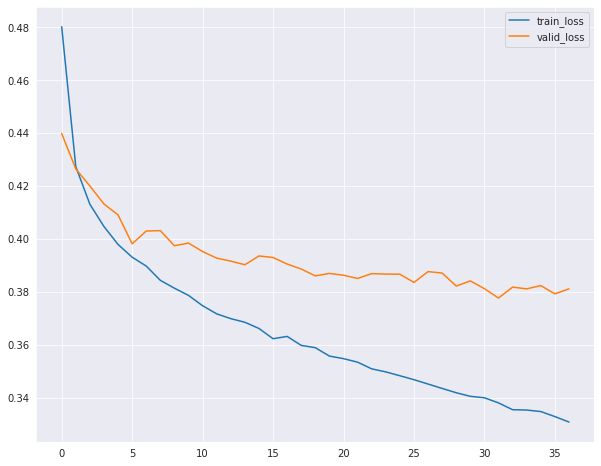

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
n_epochs = len(net.history)
sns.lineplot(range(n_epochs), net.history[:, 'train_loss'])
sns.lineplot(range(n_epochs), net.history[:, 'valid_loss'])
ax.legend(['train_loss', 'valid_loss'])

In [13]:
prob = net.predict_proba(x_test)
y_pred = net.predict(x_test)

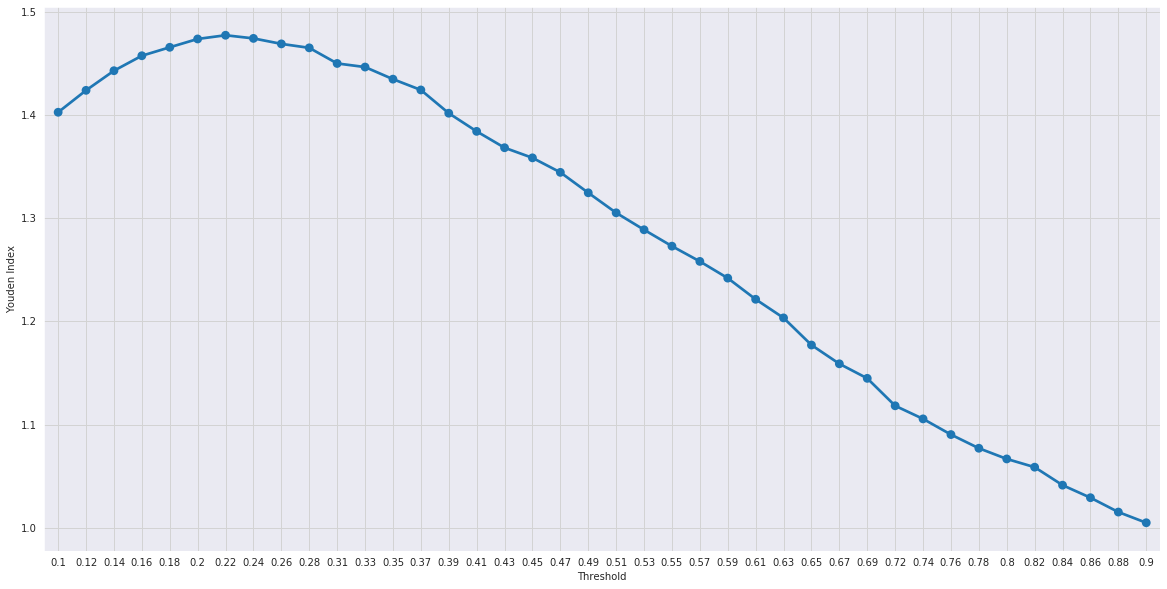

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

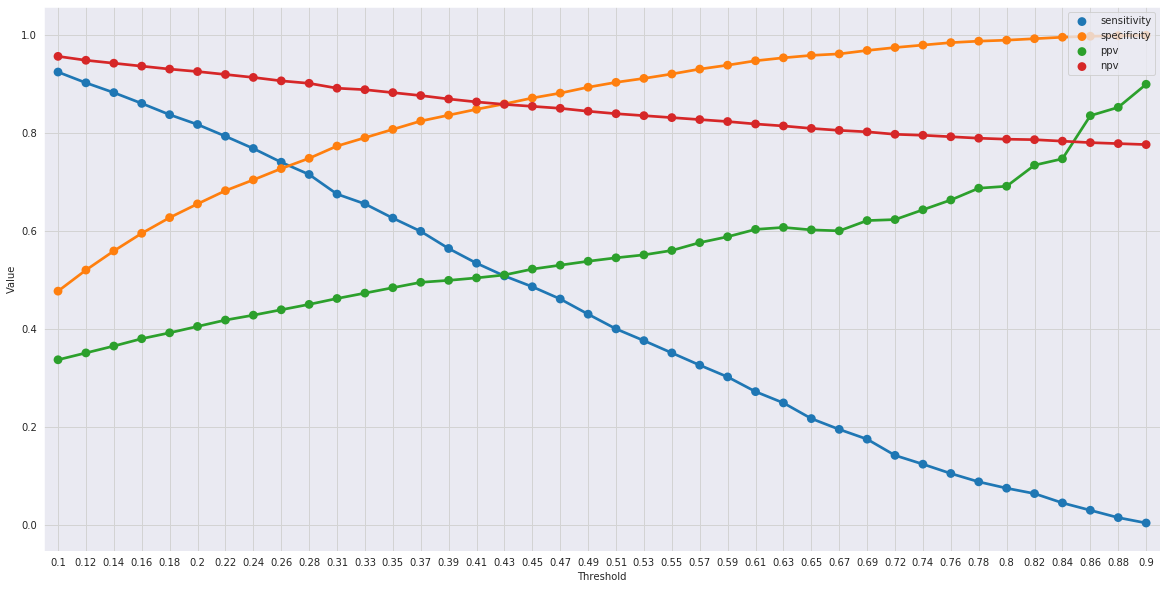

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.9, 40)

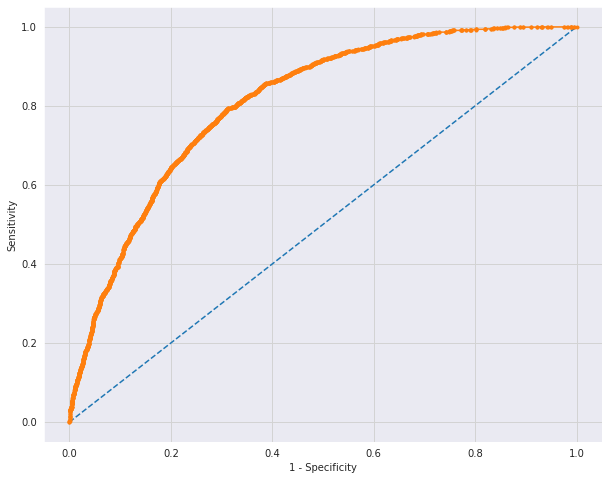

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [17]:
threshold = 0.2
y_pred = (prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.818
specificity,0.656
ppv,0.406
npv,0.926
f1,0.543
auroc,0.809


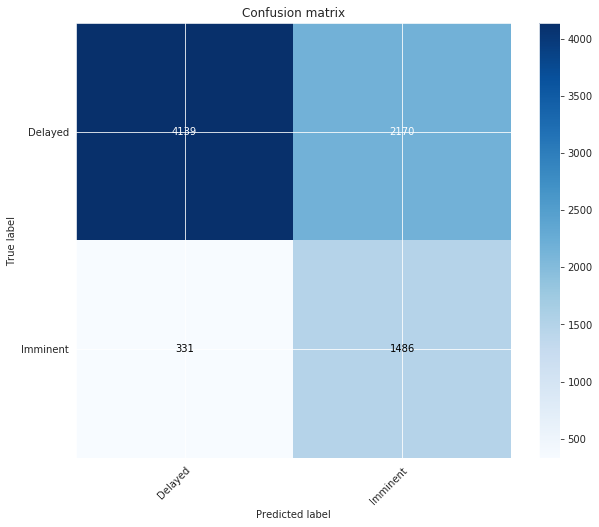

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

### Prolonged ICU Stay

In [19]:
ori_df = set_group_splits(ps_df.copy(), group_col='hadm_id', seed=seed)
df = ori_df
# df = ori_df.sample(1000).reset_index(drop=True)

split  prolonged_stay_label
test   0                       6049 
       1                       2937 
train  0                       31574
       1                       20270
dtype: int64

In [20]:
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), binary=True, max_features=60_000)

x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note']).astype(np.float32)
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note']).astype(np.float32)

x_train = np.asarray(x_train.todense())
x_test = np.asarray(x_test.todense())

vocab_sz = len(vectorizer.vocabulary_)

y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60830, 4), (51844, 60000), (8986, 60000), (51844,), (8986,))

In [21]:
train_ds = TensorDataset(torch.tensor(x_train), torch.tensor(y_train.astype(np.float32)))
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, drop_last=True)
itr = iter(train_dl)

In [22]:
clf = MLPModule(input_units=vocab_sz, output_units=1, hidden_units=args.hidden_dim, num_hidden=1, dropout=args.dropout_p, squeeze_output=True)
loss_fn = nn.BCEWithLogitsLoss()

In [23]:
x, y = next(itr)
y_pred = clf(x)
loss_fn(y_pred, y)

tensor(0.6960, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [24]:
reduce_lr = LRScheduler(
  policy='ReduceLROnPlateau',
  mode='min',
  factor=0.5,
  patience=1,
)

checkpoint = Checkpoint(
  dirname=args.workdir/'models/ps_dev_run1',
)

In [25]:
net = NeuralNetBinaryClassifier(
  clf,
  max_epochs=args.max_epochs,
  lr=args.lr,
  device=args.device,
  optimizer=optim.Adam,
  optimizer__weight_decay=args.wd,
  batch_size=args.batch_size,
  verbose=1,
  callbacks=[EarlyStopping, checkpoint, reduce_lr],
  train_split=CVSplit(cv=0.15, stratified=True),
  iterator_train__shuffle=True, 
)

net.set_params(callbacks__valid_acc=None);

In [26]:
net.fit(x_train, y_train.astype(np.float32))
# net.initialize()
# net.load_params(checkpoint=checkpoint)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.6477        0.6268     +  8.4327
      2        0.6097        0.6014     +  8.4466
      3        0.5835        0.5835     +  8.4295
      4        0.5647        0.5744     +  8.2979
      5        0.5517        0.5582     +  8.4269
      6        0.5407        0.5621        8.9295
      7        0.5325        0.5466     +  8.5110
      8        0.5258        0.5488        8.4938
      9        0.5186        0.5441     +  8.4837
     10        0.5130        0.5436     +  8.4384
     11        0.5072        0.5444        8.5448
     12        0.5015        0.5371     +  8.5061
     13        0.4957        0.5308     +  8.4664
     14        0.4912        0.5315        8.4644
     15        0.4872        0.5309        8.4679
     16        0.4821        0.5250     +  8.4833
     17        0.4763        0.5242     +  8.4849
     18        0.4728        0.5288        8.4723


<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=MLPModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=60000, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1)
      (3): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

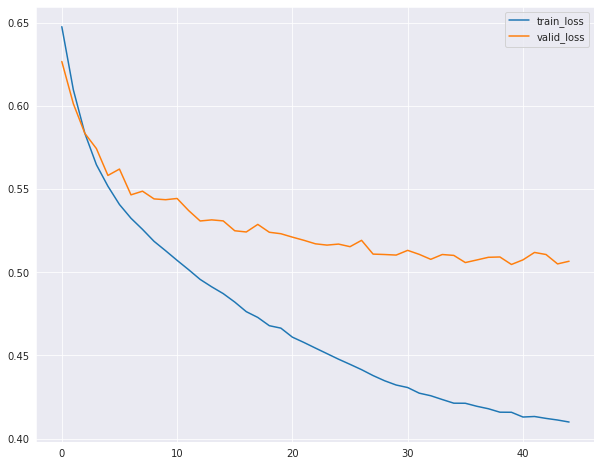

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
n_epochs = len(net.history)
sns.lineplot(range(n_epochs), net.history[:, 'train_loss'])
sns.lineplot(range(n_epochs), net.history[:, 'valid_loss'])
ax.legend(['train_loss', 'valid_loss'])

In [28]:
prob = net.predict_proba(x_test)
y_pred = net.predict(x_test)

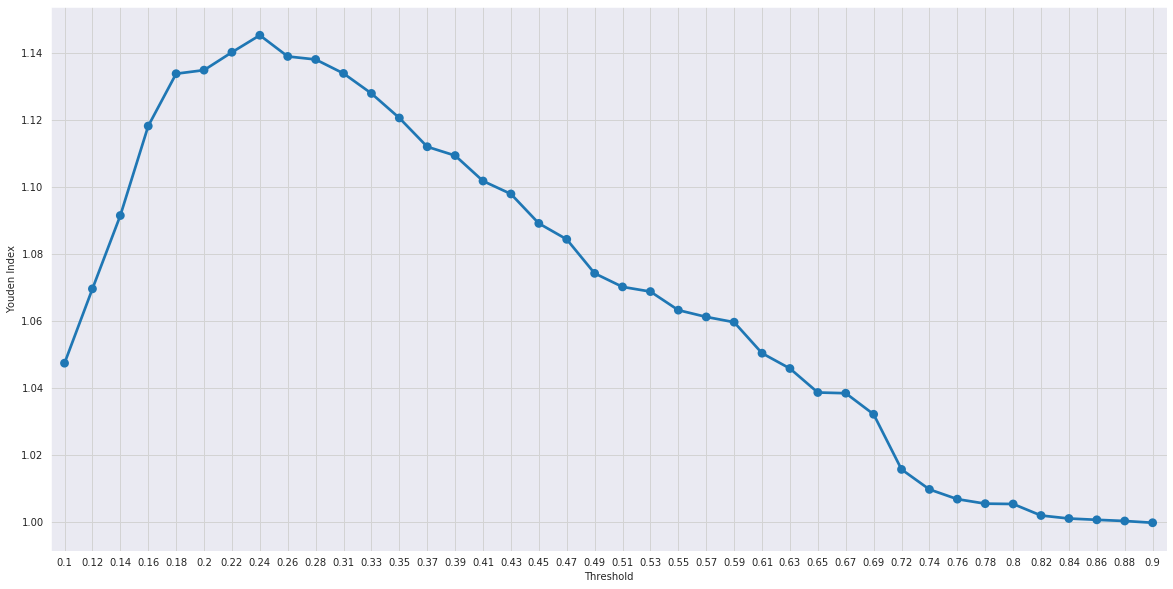

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

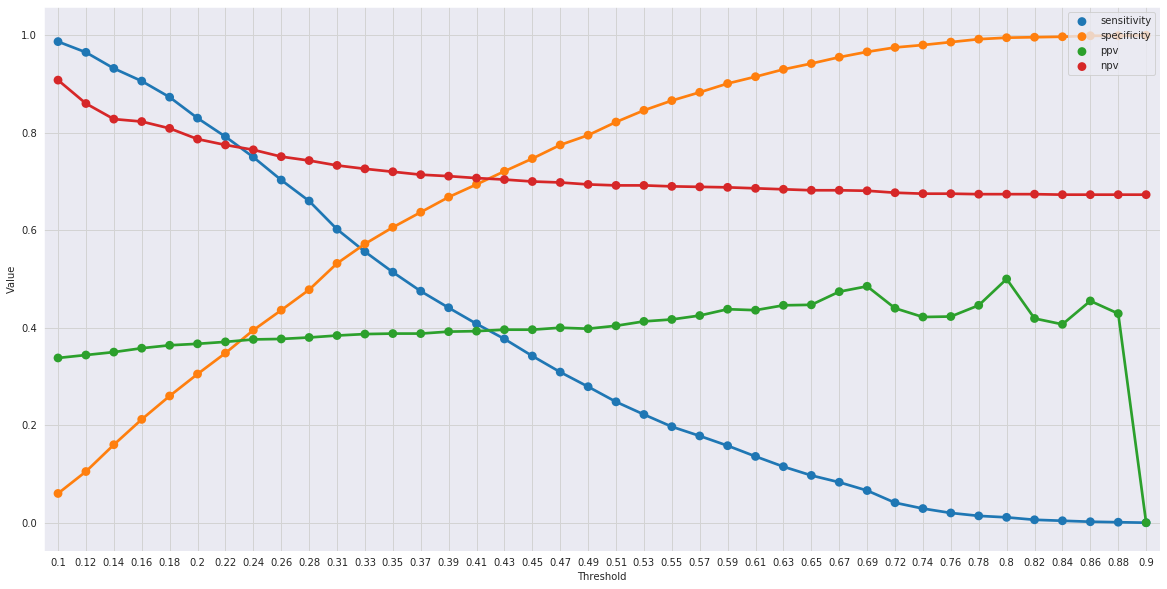

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.9, 40)

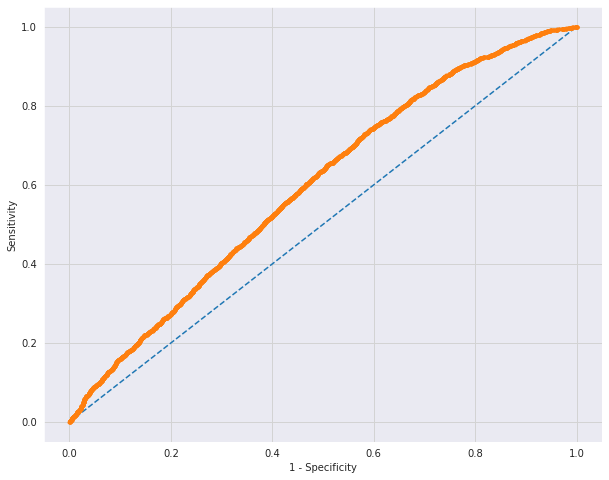

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [34]:
threshold = 0.25
y_pred = (prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.730
specificity,0.416
ppv,0.378
npv,0.760
f1,0.498
auroc,0.597


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

## Metrics

### Imminent ICU Admission

In [ ]:
with open(args.workdir/f'imminent_adm_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'imminent_adm_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

### Prolonged ICU Stay

In [ ]:
with open(args.workdir/f'prolonged_stay_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'prolonged_stay_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=False, title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=True, title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Run

In [ ]:
seed = 643
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ori_df['relative_charttime'] = (ori_df['charttime'] - ori_df['intime'])

ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols + ['relative_charttime']].reset_index(drop=True)

ps_df = ori_df.loc[(ori_df['chartinterval'] != 0)][args.prolonged_stay_cols + ['relative_charttime']].reset_index(drop=True)

In [ ]:
interval_hours = 12
starting_day = -20
ending_day = -1

### Imminent ICU Admission

In [ ]:
df = set_group_splits(ia_df.copy(), pct=0.25, group_col='hadm_id', seed=seed)
df['prob'] = -1

In [ ]:
vectorizer = TfidfVectorizer(min_df=args.min_freq, binary=True, analyzer=str.split, sublinear_tf=True)

x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note']).astype(np.float32)
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note']).astype(np.float32)

x_train = np.asarray(x_train.todense())
x_test = np.asarray(x_test.todense())

vocab_sz = len(vectorizer.vocabulary_)

y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()

df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
train_ds = TensorDataset(torch.tensor(x_train), torch.tensor(y_train.astype(np.float32)))
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, drop_last=True)
itr = iter(train_dl)

clf = MLPModule(input_units=vocab_sz, output_units=1, hidden_units=args.hidden_dim, num_hidden=1, dropout=args.dropout_p, squeeze_output=True)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
x, y = next(itr)
y_pred = clf(x)

loss_fn(y_pred, y)

In [ ]:
reduce_lr = LRScheduler(
  policy='ReduceLROnPlateau',
  mode='min',
  factor=0.5,
  patience=1,
)

checkpoint = Checkpoint(
  dirname=args.workdir/'models/ia_full_run_01',
)

In [ ]:
clf = MLPModule(input_units=vocab_sz, output_units=1, hidden_units=args.hidden_dim, num_hidden=1, dropout=args.dropout_p, squeeze_output=True)

args.batch_size=64
args.device='cuda:2'

In [ ]:
net = NeuralNetBinaryClassifier(
  clf,
  max_epochs=args.max_epochs,
  lr=args.lr,
  device=args.device,
  optimizer=optim.Adam,
  optimizer__weight_decay=args.wd,
  batch_size=args.batch_size,
  verbose=1,
  callbacks=[EarlyStopping, checkpoint, reduce_lr],
  train_split=CVSplit(cv=0.15, stratified=True),
  iterator_train__shuffle=True, 
#   iterator_train__num_workers=4,
#   iterator_train__pin_memory=True,
#   iterator_train__drop_last=True,
#   iterator_valid__num_workers=4,
#   iterator_valid__pin_memory=True,
  threshold=args.ia_thresh,
)

net.set_params(callbacks__valid_acc=None);

In [ ]:
net.fit(x_train, y_train.astype(np.float32))
# net.initialize()
# net.load_params(checkpoint=checkpoint)